In [1]:
import pandas as pd
import numpy as np
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, LpBinary
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

df_players = pd.read_parquet('df_players.parquet')
df_positions = pd.read_parquet('df_positions.parquet')
df_teams = pd.read_parquet('df_teams.parquet')

In [2]:
# Budget
my_budget = 40.0  

# Liste des noms des joueurs à ajouter
selected_names = ["Sánchez", "Dúbravka", "Guéhi", "Senesi", "Van de Ven", "Konsa", "Rodon", "M.Salah", "Reijnders",  
                   "Semenyo", "B.Fernandes", "Caicedo", "", "João Pedro", "Haaland", "Kroupi.Jr"]  # Remplace par les noms souhaités

# Filtrer df_players pour obtenir les joueurs sélectionnés
df_my_team = df_players[df_players["web_name"].isin(selected_names)]

# Afficher l'équipe sélectionnée
df_my_team.sort_values(by = ['position'])

,first_name,web_name,team_short,team_name,position,price,total_points,points_per_cost,points_per_minutes,fdr_next_6,ict_index,selected_by_percent,selected_rank,form,minutes,transfers_in,transfers_in_event,transfers_out,transfers_out_event,assists,goals_scored,goal_involvements,expected_goals,expected_assists,expected_goal_involvements,GI_on_xGI,expected_goals_per_90,saves_per_90,expected_assists_per_90,expected_goal_involvements_per_90,expected_goals_conceded_per_90,goals_conceded_per_90,defensive_contribution_per_90,minutes_last,xGI_last,xG_last,ict_last,total_points_last,total_points_last_per_xGI_last
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
260,Marc,Guéhi,CRY,Crystal Palace,DEF,47.0,43.0,0.914894,0.079630,3.333333,18.0,25.9,10,8.8,540.0,1954035,53527,411308,1516,2.0,1.0,3.0,0.39,0.08,0.47,6.382979,0.06,0.00,0.01,0.07,1.16,0.50,7.83,90.000000,0.078333,0.065000,3.000000,7.166667,91.489362
72,Marcos,Senesi,BOU,Bournemouth,DEF,48.0,43.0,0.895833,0.079630,3.166667,20.2,18.5,19,8.0,540.0,2176131,53920,174115,1359,2.0,0.0,2.0,0.14,0.37,0.51,3.921569,0.02,0.00,0.06,0.08,0.91,1.17,13.50,90.000000,0.085000,0.023333,3.366667,7.166667,84.313725
348,Joe,Rodon,LEE,Leeds,DEF,40.0,29.0,0.725000,0.053704,2.666667,10.5,4.6,76,5.0,540.0,439453,14620,148481,926,0.0,1.0,1.0,0.33,0.01,0.34,2.941176,0.06,0.00,0.00,0.06,1.22,1.50,9.33,90.000000,0.056667,0.055000,1.750000,4.833333,85.294118
575,Micky,Van de Ven,TOT,Spurs,DEF,47.0,29.0,0.617021,0.059917,2.666667,16.3,34.4,7,4.2,484.0,1568694,12114,599382,4031,0.0,1.0,1.0,0.69,0.16,0.85,1.176471,0.13,0.00,0.03,0.16,1.15,0.56,5.76,80.666667,0.141667,0.115000,2.716667,4.833333,34.117647
38,Ezri,Konsa,AVL,Aston Villa,DEF,45.0,12.0,0.266667,0.035821,3.333333,8.5,11.5,37,2.2,335.0,176643,1432,1097306,5497,0.0,0.0,0.0,0.00,0.07,0.07,0.000000,0.00,0.00,0.02,0.02,1.86,1.07,4.84,55.833333,0.011667,0.000000,1.416667,2.000000,171.428571
249,João Pedro,João Pedro,CHE,Chelsea,FWD,78.0,37.0,0.474359,0.072549,2.833333,36.3,67.7,1,5.0,510.0,2665845,11385,1074210,51766,3.0,2.0,5.0,1.50,0.23,1.73,2.890173,0.26,0.00,0.04,0.30,1.22,1.24,4.94,85.000000,0.288333,0.250000,6.050000,6.166667,21.387283
430,Erling,Haaland,MCI,Man City,FWD,143.0,59.0,0.412587,0.117296,3.000000,52.2,50.3,3,11.0,503.0,3339690,121431,613256,870,1.0,8.0,9.0,7.35,0.57,7.92,1.136364,1.32,0.00,0.10,1.42,1.14,0.89,4.29,83.833333,1.320000,1.225000,8.700000,9.833333,7.449495
100,Eli Junior,Kroupi.Jr,BOU,Bournemouth,FWD,45.0,7.0,0.155556,0.333333,3.166667,0.2,1.5,151,1.2,21.0,180391,3830,131103,1696,0.0,1.0,1.0,0.23,0.00,0.23,4.347826,0.99,0.00,0.00,0.99,1.33,4.29,8.57,3.500000,0.038333,0.038333,0.033333,1.166667,30.434783
470,Martin,Dúbravka,BUR,Burnley,GKP,40.0,18.0,0.450000,0.033333,3.166667,14.3,34.5,6,2.5,540.0,724179,5736,386320,4136,0.0,0.0,0.0,0.00,0.00,0.00,NaN,0.00,4.00,0.00,0.00,2.06,2.17,0.00,90.000000,0.000000,0.000000,2.383333,3.000000,0.000000


In [3]:
df_my_team.sum(numeric_only=True)['price'] # Coût total de l'équipe sélectionnée

np.float64(1007.0)

In [4]:
# Je dois composer une équipe de 15 joueurs, je veux savoir si je peux l'améliorer en respectant les contraintes suivantes :
# Mon budget est défini par la valeur my_budget (paramètre à modifier)
# Je dois respecter la composition d'équipe suivante : 2 Gardiens (GKP), 5 Défenseurs (DEF), 5 Milieux (MID), 3 Attaquants (FWD)
# Je ne peux pas avoir plus de 3 joueurs appartenant à la même équipe
# Je veux maximiser le nombre de points que mon équipe peut potentiellement rapporter
# Les critères me permettant de déterminer si un joueur va performer : les points_per_cost, l'ict_index, les points_per_minutes, le fdr_next_6 (plus la valeur est basse, plus le calendrier est facile et donc le joueur a de chances de performer)
# La base de données df_players contient les informations nécessaires pour chaque joueur
# A l'aide de Pulp, je vais résoudre ce problème d'optimisation linéaire en utilisant la programmation linéaire 

In [5]:
corr = df_players['ict_index'].corr(df_players['total_points'])
print(f"Corrélation entre ict_index et total_points : {corr:.3f}")


Corrélation entre ict_index et total_points : 0.872


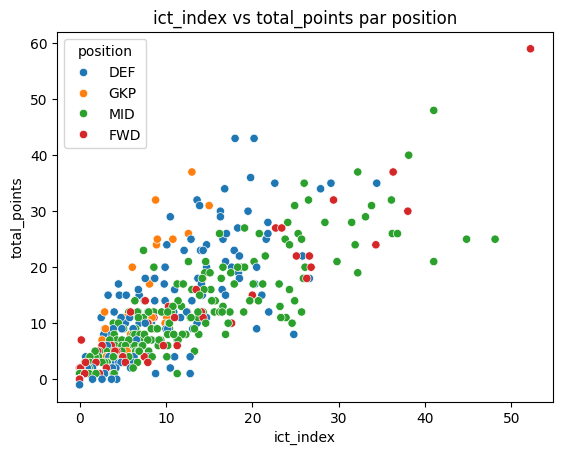

In [6]:
sns.scatterplot(data=df_players, x='ict_index', y='total_points', hue='position')
plt.title('ict_index vs total_points par position')
plt.show()


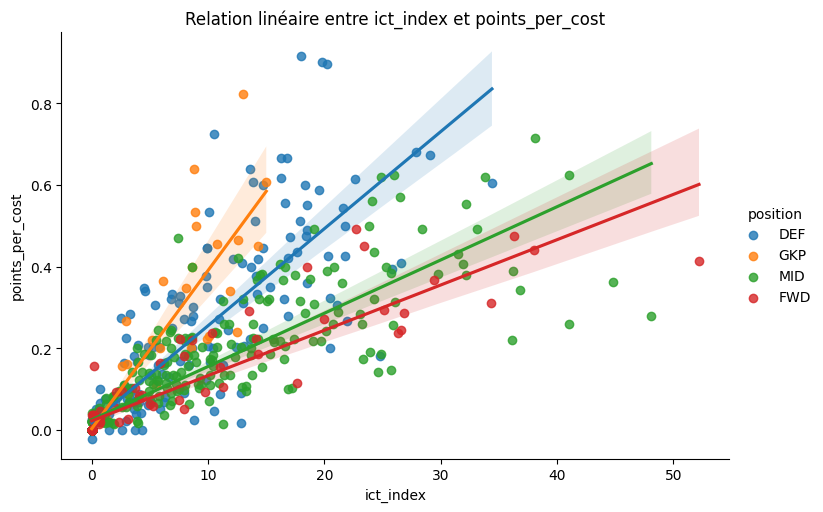

In [7]:
sns.lmplot(data=df_players, x='ict_index', y='points_per_cost', hue='position', aspect=1.5)
plt.title('Relation linéaire entre ict_index et points_per_cost')
plt.show()

In [8]:
import plotly.express as px

fig = px.scatter(
    df_players[df_players['position'] == 'MID'],  # Filtrer pour éviter les joueurs sans minutes
    x='ict_index',
    y='points_per_cost',
    text='web_name',  # Affiche le nom au survol
    color='position', # Optionnel, couleur par poste
    title='ict_index vs points_per_cost (Hover pour nom du joueur)'
)

fig.update_traces(marker=dict(size=10, opacity=0.7),
                  selector=dict(mode='markers'))
fig.update_layout(hovermode='closest')
fig.show()

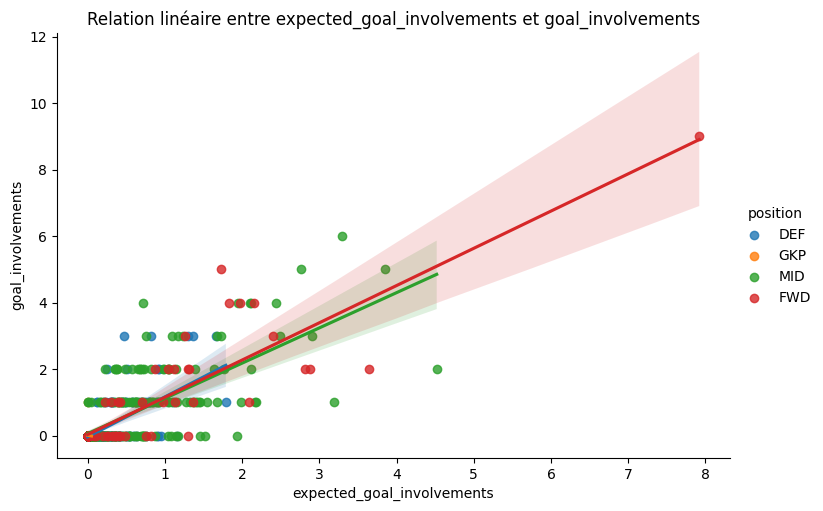

In [9]:
sns.lmplot(data=df_players, x='expected_goal_involvements', y='goal_involvements', hue='position', aspect=1.5)
plt.title('Relation linéaire entre expected_goal_involvements et goal_involvements')
plt.show()


In [10]:
import plotly.express as px

fig = px.scatter(
    df_players,
    x='expected_goal_involvements',
    y='goal_involvements',
    text='web_name',  # Affiche le nom au survol
    color='position', # Optionnel, couleur par poste
    title='Relation linéaire entre expected_goal_involvements et goal_involvements (Hover pour nom du joueur)'
)

fig.update_traces(marker=dict(size=10, opacity=0.7),
                  selector=dict(mode='markers'))
fig.update_layout(hovermode='closest')
fig.show()